<a href="https://colab.research.google.com/github/hrishipoola/spotify_dynamic_beta/blob/main/Dynamic_Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify: Dynamic Conditional Beta

## Table of Contents
1. Introduction
2. Install & Import Packages
3. **Spotify**
<br>Collect Data
<br>Specify & Fit GARCH models
<br>Goodness of Fit
<br>Parameter Significance Testing
<br>Standardized Residuals (ACF plot, Ljung-Box)
4. **S&P500**
<br>Collect Data
<br>Specify & Fit GARCH models
<br>Goodness of Fit
<br>Parameter Significance Testing
<br>Standardized Residuals (ACF plot, Ljung-Box)
5. Spotify's Dynamic Conditional Beta

## 1. Introduction

Spotify (ticker: SPOT), which went public cash flow-positive as a [direct listing](https://corpgov.law.harvard.edu/2018/07/05/spotify-case-study-structuring-and-executing-a-direct-listing/) back in April 3, 2018, is one of my favorite positions and companies to follow. Today, let's explore SPOT's [dynamic conditional $\beta$](https://www.frbsf.org/economic-research/files/Thu_1340_Engle.pdf). We'll build alot on [our previous post on GARCH models]((https://crawstat.com/2021/01/20/moderna-modeling-volatility-with-garch/). 

Traditional fixed [$\beta$](https://en.wikipedia.org/wiki/Beta_(finance)), or risk (volatility) relative to the general market (S&P500) (systematic, or non-diversifiable, risk), which is calculated as correlation between stock and market multiplied by stock volatility divided by market volatility ($\beta$ = $\rho$ x $\sigma_{stock}$ / $\sigma_{market}$). Dynamic conditional $\beta$ is a more realistic estimate of systemic risk as it takes into account the time-varying character of $\beta$: 

$\beta = \rho_{standardized-residuals}$ x (conditional $\sigma_{stock}$ / conditional $\sigma_{market})$

Let's generate SPOT's dynamic conditional $\beta$ by specifying and fitting GARCH models for SPOT and S&P500, selecting the optimal GARCH model, deriving conditional volatility and standardized residuals and correlation between standardized residuals, and, lastly, calculating and plotting dynamic conditional $\beta$. By accounting for clustering of volatility, we'll get a more realistic picture of Spotify's systemic, non-diversifiable risk over time in order to more accurately forecast and manage risk (e.g., reallocate).

## 2. Install & Import Packages

In [84]:
!pip install yfinance
!pip install pandas-datareader

# Import yfinance to make Yahoo Finance API call 
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from datetime import datetime
from functools import reduce 

# Import data reader to directly convert Yahoo Finance data into dataframe
from pandas_datareader import data as pdr

!pip install arch
from arch import arch_model

# ACF plot of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf

# Ljunb-Box test of standardized residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set seaborn plot style
sns.set_style("darkgrid")

# Set matplotlib plot style
style.use("fivethirtyeight")

## 3. Spotify

### Collect Data

In [85]:
def spotify_prices_returns(ticker, start_date, end_date):
  global spotify
  spotify = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)[['Adj Close']]
  spotify['return'] = spotify.pct_change() * 100
  spotify.dropna(inplace=True)
  return spotify

spotify_prices_returns('SPOT','2018-04-03','2021-01-29')

,Adj Close,return
Date,,
2018-04-04,144.220001,-3.214545
2018-04-05,143.990005,-0.159476
2018-04-06,147.919998,2.729351
2018-04-09,150.000000,1.406167
2018-04-10,154.899994,3.266663
...,...,...
2021-01-25,333.609985,-1.578359
2021-01-26,337.010010,1.019161
2021-01-27,330.190002,-2.023681


Text(2019-06-25 00:00:00, 353.1099853515625, 'Acquires The Ringer')

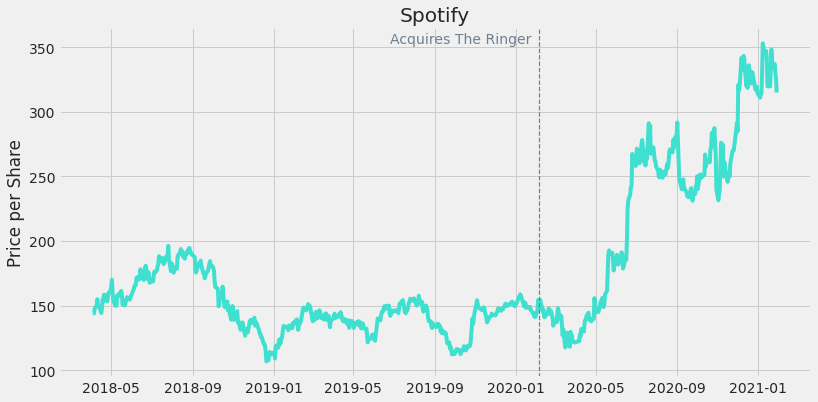

In [86]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(spotify['Adj Close'], color='turquoise')
ax.set(title='Spotify', ylabel='Price per Share') 
ax.axvline(pd.to_datetime('2020-02-05'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2019-06-25'), max(spotify['Adj Close']), 'Acquires The Ringer', color='slategray')

[Text(0, 0.5, '% Return'), Text(0.5, 1.0, 'Spotify')]

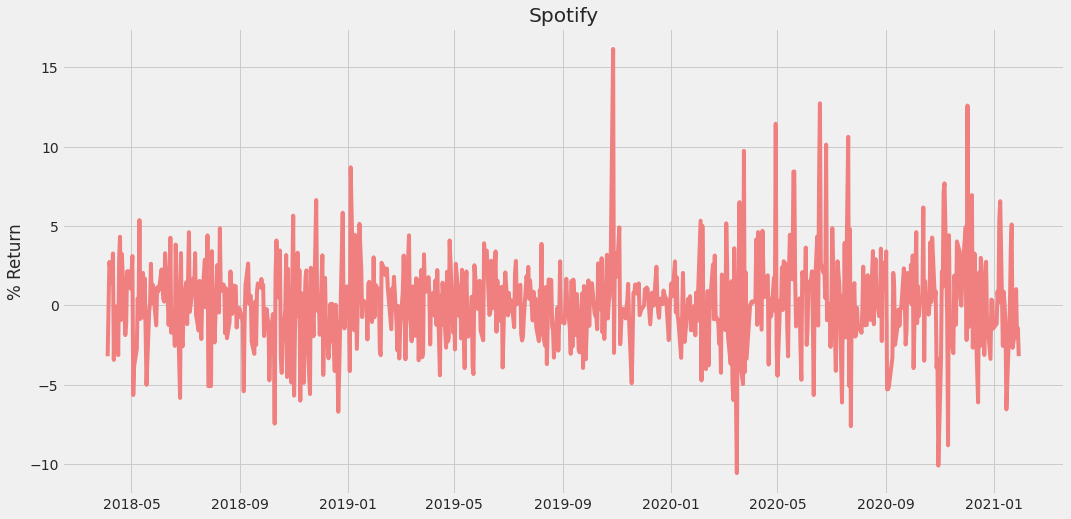

In [87]:
# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(spotify['return'], color='lightcoral')
ax.set(title='Spotify', ylabel='% Return') 

Spotify returns show clear signs of clustering

In [88]:
def volatilities(df):
  daily_volatility = df['return'].std()
  monthly_trade_days = 21; monthly_volatility = np.sqrt(monthly_trade_days) * daily_volatility
  yearly_trade_days = 252; yearly_volatility = np.sqrt(yearly_trade_days) * daily_volatility
  volatility_dict = {'daily':daily_volatility, 'monthly':monthly_volatility, 'yearly':yearly_volatility}
  volatility_df = pd.DataFrame.from_dict(volatility_dict, orient='index', columns=['volatility(%)'])
  return volatility_df

volatilities(spotify)

,volatility(%)
daily,2.869781
monthly,13.150986
yearly,45.556353


### Specify & Fit GARCH Models

In [89]:
# GARCH with constant mean, normally distributed standardized residuals
basic_gm = arch_model(spotify['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
gm_result = basic_gm.fit(disp='off')

In [90]:
gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1741.36
Distribution:                  Normal   AIC:                           3490.72
Method:            Maximum Likelihood   BIC:                           3508.99
                                        No. Observations:                  712
Date:                Mon, Feb 01 2021   Df Residuals:                      708
Time:                        14:36:36   Df Model:                            4
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0981  9.580e-02      1.024      0.306 [-8.967e-02,  0.286]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5045      0.949      0.531      0.595    [ -1.356,  2.365]
alpha[1]       0.0736  8.156e-02      0.903      0.367 [-8.624e-02,  0.233]
beta[1]        0.8675      0.187      4.644  3.422e-06    [  0.501,  1.234]
===========================================================================

Covariance estimator: robust
"""

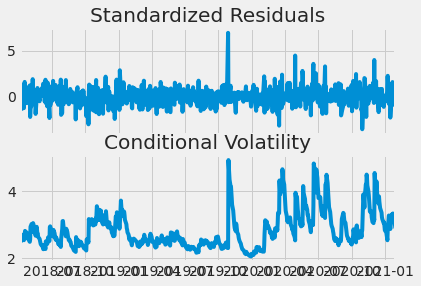

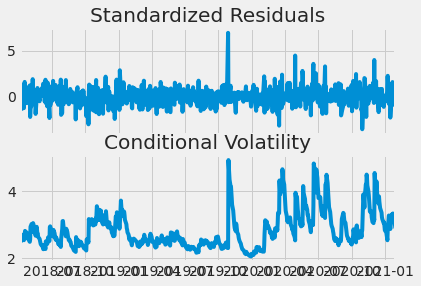

In [91]:
gm_result.plot()

In [92]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                h.1       h.2       h.3       h.4       h.5
Date                                                       
2021-01-29  8.55276  8.553351  8.553908  8.554433  8.554926


[Text(0.5, 1.0, 'Distribution of Standardized Residuals')]

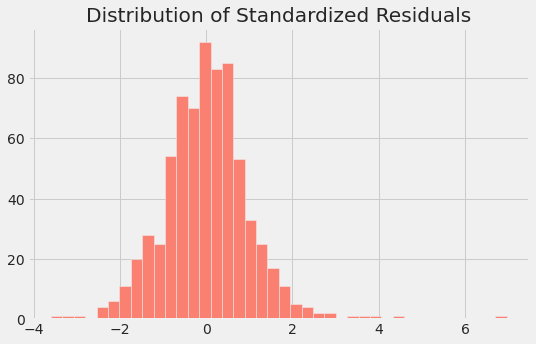

In [93]:
# Calculate standardized residual
gm_std_resid = gm_result.resid / gm_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(gm_std_resid, color='salmon', bins=40)
ax.set(title='Distribution of Standardized Residuals')

The distribution of standardized residuals looks more like a t distribution (fatter tails than normal distribution) and has a skew. Let's try fitting several GARCH models with assumptions for mean and distribution of standardized residuals and compare their fit to see which one performs best.

In [94]:
# Constant mean, normal distribution
basic_gm = arch_model(spotify['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
gm_result = basic_gm.fit(disp='off')

# Constant mean, skew t distribution
skewt_gm = arch_model(spotify['return'], p=1, q=1, mean='constant', vol='GARCH', dist='skewt') 
skewt_result = skewt_gm.fit(disp='off')

# Autoregressive mean, skew t distribution 
armean_gm = arch_model(spotify['return'], p=1, q=1, mean='AR', lags=1, vol='GARCH', dist='skewt') 
armean_result = armean_gm.fit(disp='off')

# EGARCH (asymmetric shock) with constant mean, skew t distribution
egarch_gm = arch_model(spotify['return'], p=1, q=1, o=1, mean='constant', vol='EGARCH', dist='skewt') 
egarch_result = egarch_gm.fit(disp='off')

# GJR-GARCH (asymmetric shock) with constant mean, skew t distribution
gjrgarch_gm = arch_model(spotify['return'], p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
gjrgarch_result = gjrgarch_gm.fit(disp='off')

### Goodness of Fit

In [95]:
# Function to create dataframe of log likelihood, AIC, BIC for each model
def goodness_of_fit():
  global df
  model_names = ['normal', 'skewt','AR-skewt', 'EGARCH', 'GJR-GARCH']
  models = [gm_result, skewt_result, armean_result, egarch_result, gjrgarch_result]
  likelihood = [model.loglikelihood for model in models]
  aic = [model.aic for model in models]
  bic = [model.bic for model in models]
  dict = {'model':model_names, 'log likelihood':likelihood, 'aic':aic,'bic':bic}
  df = pd.DataFrame(dict).set_index('model')
  return df

goodness_of_fit()

,log likelihood,aic,bic
model,,,
normal,-1741.357663,3490.715327,3508.987638
skewt,-1710.739997,3433.479993,3460.888461
AR-skewt,-1706.678637,3427.357275,3459.323982
EGARCH,-1709.881773,3433.763545,3465.740090
GJR-GARCH,-1710.458236,3434.916472,3466.893018


In [96]:
# Highlight max log likelihood
df.style.highlight_max(subset='log likelihood', color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1741.357663,3490.715327,3508.987638
skewt,-1710.739997,3433.479993,3460.888461
AR-skewt,-1706.678637,3427.357275,3459.323982
EGARCH,-1709.881773,3433.763545,3465.740090
GJR-GARCH,-1710.458236,3434.916472,3466.893018


In [97]:
# Highlight min AIC, BIC
df.style.highlight_min(subset=['aic', 'bic'], color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1741.357663,3490.715327,3508.987638
skewt,-1710.739997,3433.479993,3460.888461
AR-skewt,-1706.678637,3427.357275,3459.323982
EGARCH,-1709.881773,3433.763545,3465.740090
GJR-GARCH,-1710.458236,3434.916472,3466.893018


The GARCH model with an autoregressive (AR) mean and skewed t distribution of standardized residuals performs the best - it has the highest log likelihood and lowest AIC and BIC. 

### Parameter Significance Testing 

 

In [98]:
# Get parameter stats from model summary
parameters = pd.DataFrame({'parameter': armean_result.params,
                           'p-value': armean_result.pvalues})

parameters

,parameter,p-value
Const,0.106758,2.617440e-01
return[1],-0.059562,1.437737e-01
omega,0.722472,1.709972e-01
alpha[1],0.109782,4.239728e-02
beta[1],0.806813,1.313518e-15
nu,5.417477,4.922577e-06
lambda,0.001912,9.708963e-01



The high $\alpha$ indicates a large immediate impact on residuals, while the relatively high $\beta$ indicates a persisting impact. The significant $\nu$ indicates a t-distribution, though an insignificant $\lambda$ indicates that that there's not much skew. 

To check our parameters, let's run a significance test with alpha of 0.05. We see that some of our parameters actually have a p-value above 0.05. 

Generally, we should be careful with selecting or discarding parameters based on significance testing ([article](https://robjhyndman.com/hyndsight/tests2/)) - it's possible to have an insignificant coefficient for a variable that's useful for forecasting as well as having a significant variable that's better omitted for forecasting. 

We'll also look at standardized residuals to see if our model is capturing as much relevant information as possible and our residuals are truly white noise.

### Standardized Residuals

[Text(0.5, 1.0, 'Standardized Resduals')]

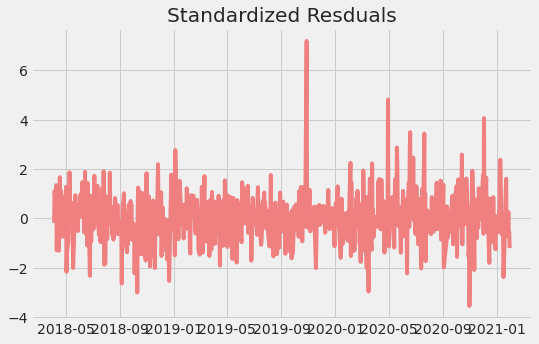

In [128]:
spotify_volatility = armean_result.conditional_volatility
spotify_std_resid = armean_result.resid / spotify_volatility
spotify_std_resid.dropna(inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(spotify_std_resid, color='lightcoral')
ax.set(title='Standardized Resduals') 

Autocorrelation tests randomness in standardized residuals for each lag and any significant autocorrelation in standardized residuals means the model may not be sound.

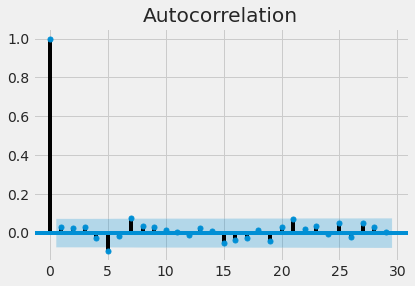

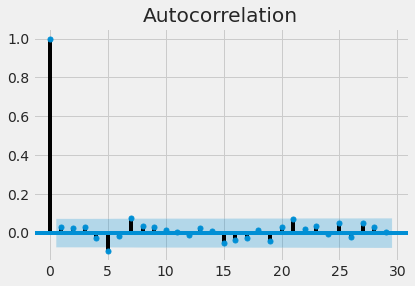

In [129]:
plot_acf(spotify_std_resid, alpha=0.05)

The ACF plots illustrate that there aren't any significant autocorrelations between residuals so the residuals represent white noise.

Ljung-Box tests for overall randomness of standardized residuals. The null hypothesis is that the data is independently distributed. P-values <5% means the residuals aren't independently distributed and the model isn't sound. 


In [101]:
# Ljung-Box test
lb_test = acorr_ljungbox(spotify_std_resid, lags=10)

# P-values dataframe, transpose to get lags as columns
p_values = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = p_values.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
p_values.columns = col_names
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,0.442216,0.624697,0.6792,0.723765,0.140751,0.204702,0.077392,0.092946,0.113207,0.15388


All the p-values are above 5% meaning the null hypothesis can't be rejected and the standardized residuals are independently distributed. 

## 4. S&P500

### Collect Data

In [102]:
def sp500(ticker, start_date, end_date):
  global sp
  sp = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)[['Adj Close']]
  sp['return'] = sp.pct_change() * 100
  sp.dropna(inplace=True)
  return sp

sp500('^GSPC','2018-04-03','2021-01-29')

,Adj Close,return
Date,,
2018-04-04,2644.689941,1.156648
2018-04-05,2662.840088,0.686286
2018-04-06,2604.469971,-2.192025
2018-04-09,2613.159912,0.333655
2018-04-10,2656.870117,1.672695
...,...,...
2021-01-25,3855.360107,0.361584
2021-01-26,3849.620117,-0.148883
2021-01-27,3750.770020,-2.567788


[Text(0, 0.5, 'Price per Share'), Text(0.5, 1.0, 'S&P500')]

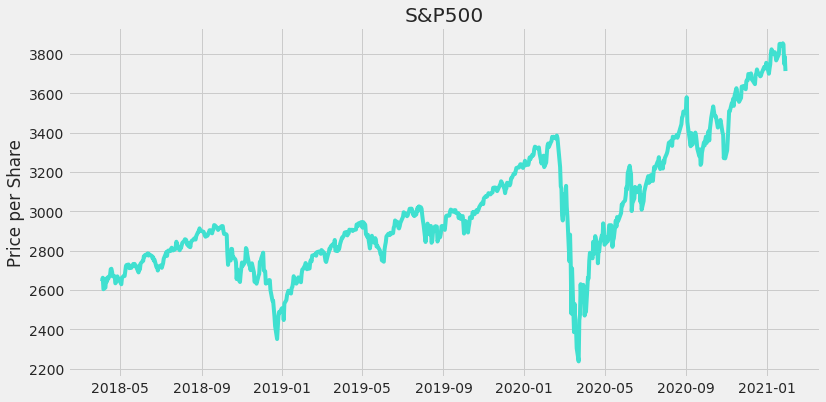

In [103]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(sp['Adj Close'], color='turquoise')
ax.set(title='S&P500', ylabel='Price per Share') 

[Text(0, 0.5, '% Return'), Text(0.5, 1.0, 'S&P500')]

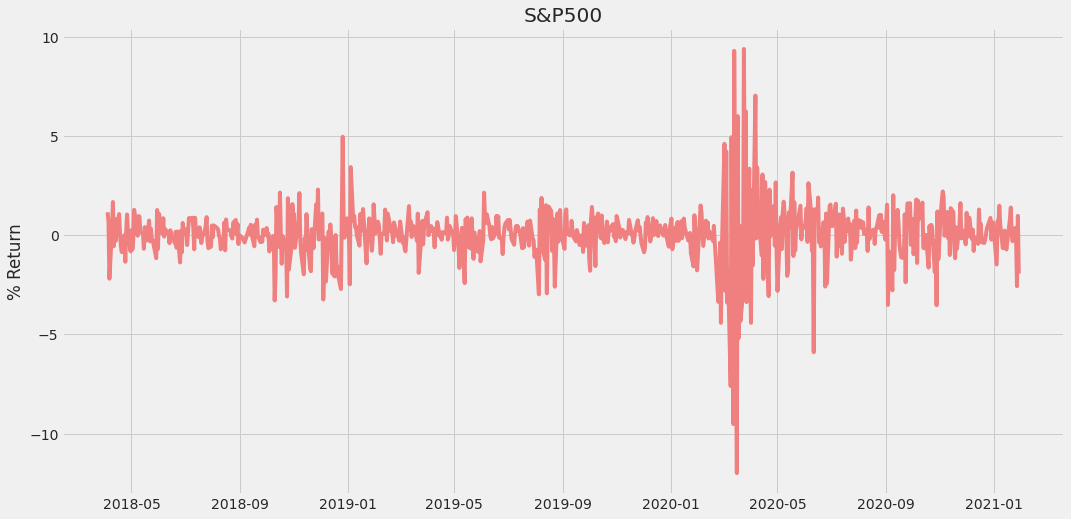

In [104]:
# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(sp['return'], color='lightcoral')
ax.set(title='S&P500', ylabel='% Return') 

S&P500 returns show clear signs of clustering.

In [105]:
volatilities(sp)

,volatility(%)
daily,1.477074
monthly,6.768803
yearly,23.447821


### Specify & Fit GARCH Models

In [106]:
# GARCH with constant mean, normally distributed standardized residuals
sp_basic_gm = arch_model(sp['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
sp_gm_result = sp_basic_gm.fit(disp='off')

In [107]:
sp_gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -992.889
Distribution:                  Normal   AIC:                           1993.78
Method:            Maximum Likelihood   BIC:                           2012.05
                                        No. Observations:                  712
Date:                Mon, Feb 01 2021   Df Residuals:                      708
Time:                        14:36:41   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1114  2.932e-02      3.798  1.458e-04 [5.389e-02,  0.169]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0437  1.780e-02      2.457  1.401e-02 [8.847e-03,7.863e-02]
alpha[1]       0.2524  5.738e-02      4.399  1.087e-05     [  0.140,  0.365]
beta[1]        0.7444  3.861e-02     19.280  7.982e-83     [  0.669,  0.820]
============================================================================

Covariance estimator: robust
"""

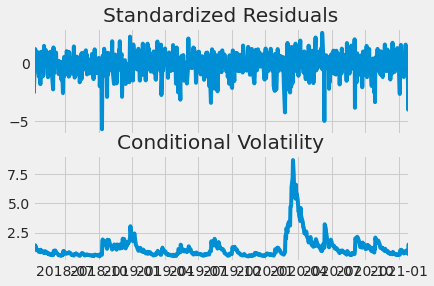

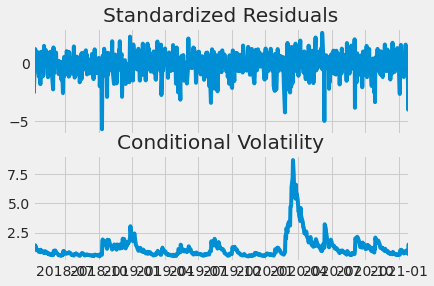

In [108]:
sp_gm_result.plot()

In [109]:
# Make 5-period ahead forecast
sp_gm_forecast = sp_gm_result.forecast(horizon = 5)

# Print the forecast variance
print(sp_gm_forecast.variance[-1:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-01-29  2.484941  2.520721  2.556386  2.591937  2.627374


[Text(0.5, 1.0, 'Distribution of Standardized Residuals')]

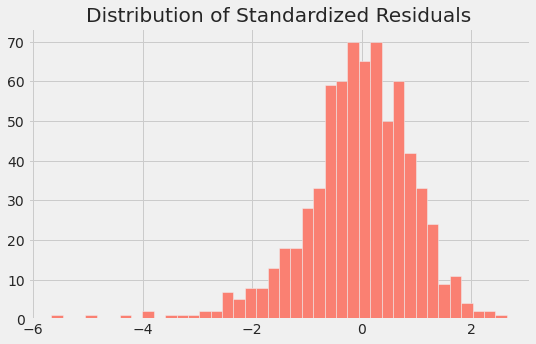

In [110]:
# Calculate standardized residual
sp_gm_std_resid = sp_gm_result.resid / sp_gm_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(sp_gm_std_resid, color='salmon', bins=40)
ax.set(title='Distribution of Standardized Residuals')

The distribution of standardized residuals deviates from a normal distribution and with a negative skew. Let's try fitting several GARCH models with assumptions for mean and distribution of standardized residuals and compare their fit to see which one performs best.

In [111]:
# Constant mean, normal distribution
sp_basic_gm = arch_model(sp['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
sp_gm_result = sp_basic_gm.fit(disp='off')

# Constant mean, skew t distribution
sp_skewt_gm = arch_model(sp['return'], p=1, q=1, mean='constant', vol='GARCH', dist='skewt') 
sp_skewt_result = sp_skewt_gm.fit(disp='off')

# Autoregressive mean, skew t distribution 
sp_armean_gm = arch_model(sp['return'], p=1, q=1, mean='AR', lags=1, vol='GARCH', dist='skewt') 
sp_armean_result = sp_armean_gm.fit(disp='off')

# EGARCH (asymmetric shock) with constant mean, skew t distribution
sp_egarch_gm = arch_model(sp['return'], p=1, q=1, o=1, mean='constant', vol='EGARCH', dist='skewt') 
sp_egarch_result = sp_egarch_gm.fit(disp='off')

# GJR-GARCH (asymmetric shock) with constant mean, skew t distribution
sp_gjrgarch_gm = arch_model(sp['return'], p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
sp_gjrgarch_result = sp_gjrgarch_gm.fit(disp='off')

### Goodness of Fit

In [112]:
# Function to create dataframe of log likelihood, AIC, BIC for each model
def sp_goodness_of_fit():
  global sp_df
  model_names = ['normal', 'skewt','AR-skewt', 'EGARCH', 'GJR-GARCH']
  models = [sp_gm_result, sp_skewt_result, sp_armean_result, sp_egarch_result, sp_gjrgarch_result]
  likelihood = [model.loglikelihood for model in models]
  aic = [model.aic for model in models]
  bic = [model.bic for model in models]
  dict = {'model':model_names, 'log likelihood':likelihood, 'aic':aic,'bic':bic}
  sp_df = pd.DataFrame(dict).set_index('model')
  return sp_df

sp_goodness_of_fit()

,log likelihood,aic,bic
model,,,
normal,-992.888508,1993.777016,2012.049327
skewt,-954.285330,1920.570660,1947.979127
AR-skewt,-949.107196,1912.214392,1944.181099
EGARCH,-944.200042,1902.400084,1934.376629
GJR-GARCH,-944.246296,1902.492592,1934.469137


In [113]:
# Highlight max log likelihood
sp_df.style.highlight_max(subset='log likelihood', color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-992.888508,1993.777016,2012.049327
skewt,-954.285330,1920.570660,1947.979127
AR-skewt,-949.107196,1912.214392,1944.181099
EGARCH,-944.200042,1902.400084,1934.376629
GJR-GARCH,-944.246296,1902.492592,1934.469137


In [114]:
# Highlight min AIC, BIC
sp_df.style.highlight_min(subset=['aic', 'bic'], color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-992.888508,1993.777016,2012.049327
skewt,-954.285330,1920.570660,1947.979127
AR-skewt,-949.107196,1912.214392,1944.181099
EGARCH,-944.200042,1902.400084,1934.376629
GJR-GARCH,-944.246296,1902.492592,1934.469137


For S&P500, EGARCH, which takes into account asymmetric shocks, performs the best - it has the highest log likelihood and lowest AIC and BIC. 

### Parameter Significance Testing


EGARCH's additional parameter $\gamma$ takes into account asymmetric shock, where I is an indicator function that equals 1 if the unconditional standard deviation is less than 0. A negative and significant $\gamma$ means bad news increases volatility more than good news of similar magnitude. A positive and significant $\gamma$ means that good news increases volatility more than bad news of the same magnitude. 

The negative $\gamma$ implies that bad news increases volatility more than good news of similar magnitude. 


In [115]:
# Get parameter stats from model summary
parameters = pd.DataFrame({'parameter': sp_egarch_result.params,
                           'p-value': sp_egarch_result.pvalues})

parameters

,parameter,p-value
mu,0.042785,1.234277e-01
omega,0.009038,5.103696e-01
alpha[1],0.220834,7.903184e-05
gamma[1],-0.165935,8.890776e-11
beta[1],0.971613,0.000000e+00
nu,6.441482,6.660853e-06
lambda,-0.273388,1.272811e-06


### Standardized Residuals

[Text(0.5, 1.0, 'Standardized Resduals')]

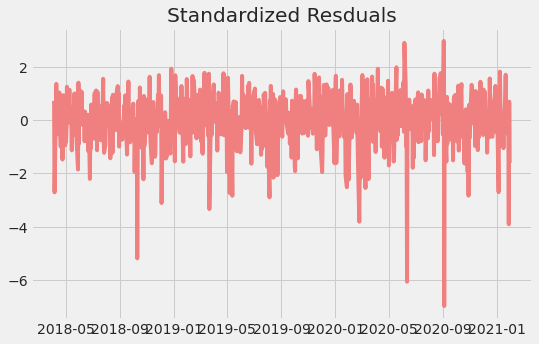

In [143]:
sp_volatility = sp_egarch_result.conditional_volatility
sp_std_resid = sp_egarch_result.resid / sp_volatility
sp_std_resid.dropna(inplace=True)
sp_std_resid = sp_std_resid[1:] # drop first row (extra day) so matches shape of spotify_std_resid

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(sp_std_resid, color='lightcoral')
ax.set(title='Standardized Resduals') 

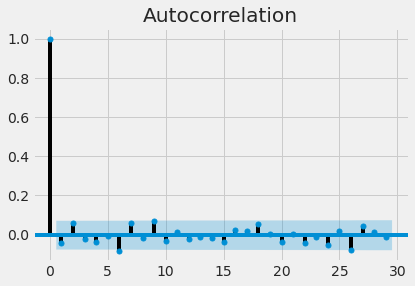

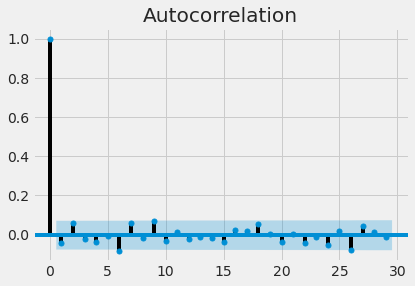

In [144]:
plot_acf(sp_std_resid, alpha=0.05)

The ACF plots illustrate that there aren't any significant autocorrelations between residuals so the residuals represent white noise.

In [120]:
# Ljung-Box test
lb_test = acorr_ljungbox(sp_std_resid, lags=10)

# P-values dataframe, transpose to get lags as columns
p_values = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = p_values.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
p_values.columns = col_names
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,0.26625,0.194432,0.300296,0.338908,0.470384,0.161451,0.109225,0.156488,0.075394,0.087357


All the p-values are above 5% meaning the null hypothesis can't be rejected and the standardized residuals are independently distributed. 

## 5. Dynamic Conditional Beta


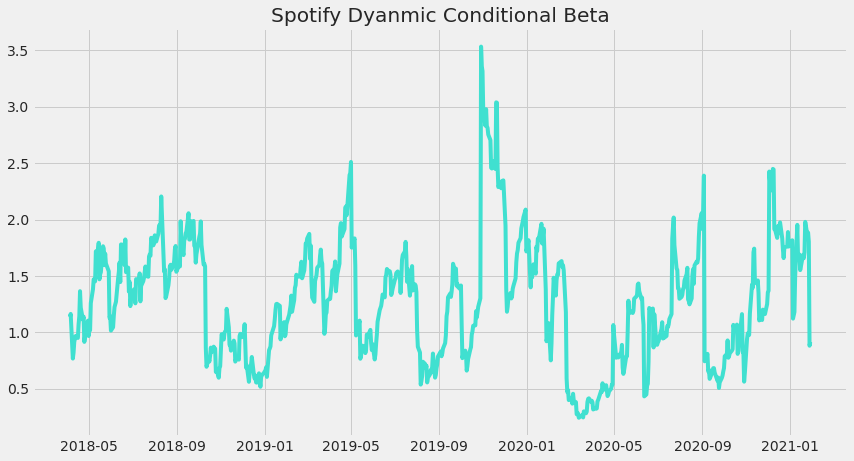

In [149]:
def beta():
  
  # Calculate beta
  correlation = np.corrcoef(spotify_std_resid, sp_std_resid)[0,1]
  spotify_beta = correlation * (spotify_volatility / sp_volatility)

  # Plot
  fig, ax = plt.subplots(figsize=(13,7))
  ax.plot(spotify_beta, color='turquoise')
  ax.set(title='Spotify Dyanmic Conditional Beta') 
  return ax

beta()